A model with real unknowns has been initialized
Rectangle (0,2.0)x(0,1.0) has been meshed
Domain has been set
Domain is set and contains 1 mesh(es):
=== on mesh 0 of dim 2
* Subdomains are: {'Omega': 1}
* Boundaries are: {'Gamma_Bottom': 10, 'Gamma_Right': 11, 'Gamma_Top': 12, 'Gamma_Left': 13}
domain: Rectangle has been set
state: T has been added
port: T has been added 
costate: T has been added to state: T
state: T has new costate: T
FEM_PK(2,1) has been set for port T
rho has been added to port: T
rho has been set to 1. in port: T
rho has been initialized with the FEM of port: T
port: Heat flux has been added 
port: Boundary control (bottom) has been added on region 10
FEM_PK(2,2) has been set for port Heat flux
Lambda has been added to port: Heat flux
Lambda has been set to [[1.,0.],[0.,1.]] in port: Heat flux
Lambda has been initialized with the FEM of port: Heat flux
port: Boundary control (right) has been added on region 11
FEM_PK(2,1) has been set for port Boundary control (bo

message from gf_mesh_get follow:
gfMesh object in dimension 2 with 80 points and 128 elements

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 80 points, 128 elements and 80 degrees of freedom

Parameter rho has been evaluated with the fem of port ' T ', with expression: 1.
message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 80 points, 128 elements and 574 degrees of freedom

Parameter Lambda has been evaluated with the fem of port ' Heat flux ', with expression: [[1.,0.],[0.,1.]]
message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 80 points, 128 elements and 80 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 80 points, 128 elements and 80 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 80 points, 128 elements and 80 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 2 with 80 points, 128 el

Elapsed time: 1.299s
Steps: 116 (5 rejected, 0 Nonlinear solver failures)
Nonlinear iterations: 128, Linear iterations: 128
Start computing the Hamiltonian
Hamiltonian has been computed in 0.021360835060477257 s
Start computing the powers (substituted ports are not automated)
Power cannot be computed for dynamic or substituted port T
Start computing the power flowing through Heat flux
Power in Heat flux has been computed in 0.024052787572145462 s
Start computing the power flowing through Boundary control (bottom)
Power in Boundary control (bottom) has been computed in 0.007412342354655266 s
Start computing the power flowing through Boundary control (right)
Power in Boundary control (right) has been computed in 0.00726453959941864 s
Start computing the power flowing through Boundary control (top)
Power in Boundary control (top) has been computed in 0.007244523614645004 s
Start computing the power flowing through Boundary control (left)
Power in Boundary control (left) has been computed 

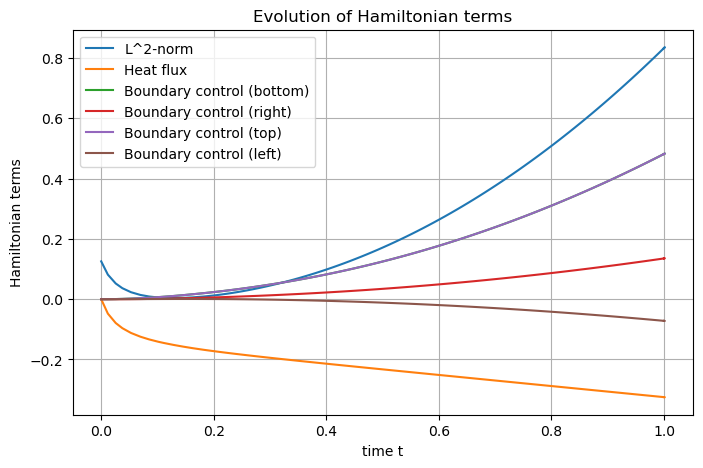

In [1]:
import scrimp as S
from itertools import zip_longest

# Init the distributed port-Hamiltonian system
heat = S.DPHS("real")

# Set the domain (using the built-in geometry `Rectangle`)
# Omega = 1, Gamma_Bottom = 10, Gamma_Right = 11, Gamma_Top = 12, Gamma_Left = 13
heat.set_domain(S.Domain("Rectangle", {"L": 2.0, "l": 1.0, "h": 0.2}))

# Define the variables and their discretizations

states = [
    S.State("T", "Temperature", "scalar-field"),
]
costates = [
    S.CoState("T", "Temperature", states[0], substituted=True)
]
ports = [
    S.Port("Heat flux", "f_Q", "e_Q", "vector-field", dissipative=True),
]
params = [
    S.Parameter("rho", "Mass density times heat capacity", "scalar-field", "1.", "T"),
    S.Parameter(
        "Lambda",
        "Heat conductivity",
        "tensor-field",
        "[[1.,0.],[0.,1.]]",
        "Heat flux",
    ),
]

control_ports = [
    S.Control_Port(
        "Boundary control (bottom)",
        "U_B",
        "Temperature",
        "Y_B",
        "Normal heat flux",
        "scalar-field",
        region=10,
        position="effort",
    ),
    S.Control_Port(
        "Boundary control (right)",
        "U_R",
        "Temperature",
        "Y_R",
        "Normal heat flux",
        "scalar-field",
        region=11,
        position="effort",
    ),
    S.Control_Port(
        "Boundary control (top)",
        "U_T",
        "Temperature",
        "Y_T",
        "Normal heat flux",
        "scalar-field",
        region=12,
        position="effort",
    ),
    S.Control_Port(
        "Boundary control (left)",
        "U_L",
        "Normal heat flux",
        "Y_L",
        "Temperature",
        "scalar-field",
        region=13,
        position="flow",
    ),
]

FEMs = [
    # name of the variable: (is the same of states, ports and controls ports), order, FEM
    S.FEM(states[0].get_name(), 1, FEM="CG"),
    S.FEM(ports[0].get_name(), 2, FEM="CG"),
    S.FEM(control_ports[0].get_name(), 1, FEM="CG"),
    S.FEM(control_ports[1].get_name(), 1, FEM="CG"),
    S.FEM(control_ports[2].get_name(), 1, FEM="CG"),
    S.FEM(control_ports[3].get_name(), 1, FEM="CG"),
]

for state, costate, param, fem, port, control_port in zip_longest(
    states, costates, params, FEMs, ports, control_ports
):
    if state is not None:
        # Add a state
        heat.add_state(state)
    if costate is not None:
        # Add its co-state
        heat.add_costate(costate)
    if fem is not None:
        # Add a Finite Element Method to the `port`
        heat.add_FEM(fem)
    if param is not None:
        # Add a (possibly space-varying) parameter to the `port`
        heat.add_parameter(param)
    if port is not None:
        # Add a resistive `port`
        heat.add_port(port)
    if control_port is not None:
        # Add a control `port` on the bottom part of the boundary (Neumann, thus position='effort' - default)
        heat.add_control_port(control_port)

# Set Hamiltonian
heat.hamiltonian.set_name("Lyapunov formulation")

terms = [
    S.Term("L^2-norm", "0.5*T*rho*T", [1]),
]

for term in terms:
    # Set the Hamiltonian (can be done later, even after solve)
    heat.hamiltonian.add_term(term)

# Define the Dirac structure via getfem `brick` = non-zero block matrix
bricks = [
    # Add the mass matrices from the left-hand side: the `flow` part of the Dirac structure
    S.Brick("M_T", "T*rho*Test_T", [1], dt=True, position="flow"),
    S.Brick("M_Q", "f_Q.Test_f_Q", [1], position="flow"),
    S.Brick("M_Y_B", "Y_B*Test_Y_B", [10], position="flow"),
    S.Brick("M_Y_R", "Y_R*Test_Y_R", [11], position="flow"),
    S.Brick("M_Y_T", "Y_T*Test_Y_T", [12], position="flow"),
    # Normal trace is imposed by Lagrange multiplier on the left side == the collocated output
    S.Brick("M_Y_L", "U_L*Test_Y_L", [13], position="flow"),
    # Add the matrices from the right-hand side: the `effort` part of the Dirac structure
    S.Brick("D", "-Div(e_Q)*Test_T", [1], position="effort"),
    S.Brick("-D^T", "T*Div(Test_f_Q)", [1], position="effort"),
    S.Brick("B_B", "-U_B*Test_f_Q.Normal", [10], position="effort"),
    S.Brick("B_R", "-U_R*Test_f_Q.Normal", [11], position="effort"),
    S.Brick("B_T", "-U_T*Test_f_Q.Normal", [12], position="effort"),
    # Normal trace is imposed by Lagrange multiplier on the left side == the collocated output
    S.Brick("B_L", "-Y_L*Test_f_Q.Normal", [13], position="effort"),
    S.Brick("C_B", "e_Q.Normal*Test_Y_B", [10], position="effort"),
    S.Brick("C_R", "e_Q.Normal*Test_Y_R", [11], position="effort"),
    S.Brick("C_T", "e_Q.Normal*Test_Y_T", [12], position="effort"),
    S.Brick("C_L", "e_Q.Normal*Test_Y_L", [13], position="effort"),
    ## Define the constitutive relations as getfem `brick`
    # Fourier's law under implicit form - M_e_Q e_Q + CR_Q Q = 0
    S.Brick("-M_e_Q", "-e_Q.Test_e_Q", [1]),
    S.Brick("CR_Q", "f_Q.Lambda.Test_e_Q", [1]),
]

for brick in bricks:
    heat.add_brick(brick)

# Initialize the problem
expressions = ["t", "t", "t", "0.2"]

for control_port, expression in zip(control_ports, expressions):
    # Set the control functions (automatic construction of bricks such that -M_u u + f(t) = 0)
    heat.set_control(control_port.get_name(), expression)

# Set the initial data
heat.set_initial_value("T", "np.exp(-50*((x-1)*(x-1)+(y-0.5)*(y-0.5))**2)")

## Solve in time

# Define the time scheme
heat.set_time_scheme(t_f=1, 
                     ts_type="bdf", 
                     ts_bdf_order=4, 
                     dt=0.01, 
                     ts_adapt_dt_min=1.e-6, 
                     ksp_type = "preonly",
                     pc_type = "lu",
                     pc_factor_mat_solver_type = "mumps",
                     )

# Solve
heat.solve()

# Post-processing

# Plot the Hamiltonian with the power supplied at the boundary
heat.plot_Hamiltonian(save_figure=True)